## 3.4 並列化をしてみよう(マルチプロセスでの並列)

**まず最初に、この章は、Masahiko G. Yamadaさん(通称MGY。12/17時点で阪大特任助教)から教えていただいた事を書いているので、この章を参考にした人は、学会等で山田さんに会ったらお礼を言いましょう。**

基本的には２重ループ等の積分計算を行う際に、並列化で速度を向上させることが多いと思う。
ので、ここではまず「Distributed」というライブラリを用いて、マルチプロセス計算を行う。

``addprocs(N)``でN個のコアでの分散処理を行う事を宣言する。（``addprocs()``で上限のコア数で分散処理を行う。ただし物理コア以上の数を指定しても性能は上がらない模様）

In [ ]:
using Distributed
addprocs(30)
#rmprocs()
#workers()

マルチプロセスで並列化を行う際に、juliaにおいては、それぞれのプロセスで関数が定義されるようなので、並列処理を行う関数については
``@everywhere``を付ける必要がある。(謎に時間がかかるので注意)

In [2]:
@everywhere struct Parm
    t::Float64
    lamda::Float64
    M::Float64
    mu::Float64
    eta::Float64
    T::Float64
    W_MAX::Float64
    K_SIZE::Int
    W_SIZE::Int
end

並列処理内でライブラリを使う場合は、``using ~``の前にも``@everywhere``を付ける。

後にOptical responseにも拡張できるよう$G^{R/A}(\omega\pm\Omega)$を実装しておく。
ちなみにいちいち速度演算子を自分で導くのが嫌な人は、「using ForwardDiff」をして「f'(x)=ForwardDiff.gradient(f,x)」(xは(kx,ky)で良い)とすると、自動微分をしてくれるので、ハミルトニアンさえ与えれば自動で速度演算子を決めてくれる。（詳しくはググってみてください）

In [3]:
@everywhere using LinearAlgebra

@everywhere mutable struct Hamiltonian
    Hk::Array{ComplexF64,2}
    Vx::Array{ComplexF64,2}
    Vy::Array{ComplexF64,2}
    Vxx::Array{ComplexF64,2}
    Vyx::Array{ComplexF64,2}
    #後々非エルミートに拡張できるようにComplexF64にしているが、別にFloat64でも良いはず
    E::Array{ComplexF64,1}
end

#遅延及び先進グリーン関数を内包する構造体
@everywhere mutable struct Green
    GR::Array{ComplexF64,2}
    GA::Array{ComplexF64,2}
    dGR::Array{ComplexF64,2}
    dGA::Array{ComplexF64,2}
    GRmA::Array{ComplexF64,2}
    GRp::Array{ComplexF64,2}
    GAm::Array{ComplexF64,2}
end

In [4]:
@everywhere function HandV_topo(k::NTuple{2, Float64},p::Parm)
    H::Array{ComplexF64,2} = [-p.t*(cos(k[1])+cos(k[2])-2.0)+p.mu+p.M p.lamda*(-sin(k[1])-im*sin(k[2]))
    p.lamda*(-sin(k[1])+im*sin(k[2])) p.t*(cos(k[1])+cos(k[2])-2.0)+p.mu-p.M]

    Vx::Array{ComplexF64,2} = [p.t*(sin(k[1])) p.lamda*(-cos(k[1]))
    p.lamda*(-cos(k[1])) -p.t*(sin(k[1]))]

    Vy::Array{ComplexF64,2} = [p.t*(sin(k[2])) p.lamda*(-im*cos(k[2]))
    p.lamda*(im*cos(k[2])) -p.t*(sin(k[2]))]

    Vxx::Array{ComplexF64,2} = [p.t*(cos(k[1])) p.lamda*(sin(k[1]))
    p.lamda*(sin(k[1])) -p.t*(cos(k[1]))]

    Vyx::Array{ComplexF64,2} = [0.0 0.0
    0.0 0.0]

    E::Array{ComplexF64,1} = zeros(2)

    return H, Vx, Vy, Vxx, Vyx, E 
end

@everywhere function Gk(w::Float64, p::Parm, Ham::Hamiltonian)
    #Green関数のinverse
    GR0::Array{ComplexF64,2} = -Ham.Hk + Matrix{Complex{Float64}}(w*I,2,2) + p.eta*Matrix{Complex{Float64}}(1.0im*I,2,2)

    GR::Array{ComplexF64,2} = inv(GR0)
    GA::Array{ComplexF64,2} = GR'
    GRmA::Array{ComplexF64,2} = GR - GA
    dGR::Array{ComplexF64,2} = - GR * GR
    dGA::Array{ComplexF64,2} = - GA * GA
    GRp = zeros(ComplexF64,2,2)
    GAm = zeros(ComplexF64,2,2)
    return GR, GA, dGR, dGA, GRmA, GRp, GAm
end

In [5]:
@everywhere f(e,T) = 1.0/(1.0+exp(e/T))
@everywhere df(e,T) = -1.0/(1.0+exp(e/T))/(1.0+exp(-e/T))/T

@everywhere function Green_LR(p::Parm, H::Hamiltonian)
    Drude::Float64 = 0.0
    QH::Float64 = 0.0

    for w = collect(Float64,-p.W_MAX:2*p.W_MAX/p.W_SIZE:p.W_MAX)
        G = Green(Gk(w,p,H)...)
        Drude += 2.0p.W_MAX*real(tr(H.Vx*G.GR*H.Vx*G.GRmA)*df(w,p.T)/p.W_SIZE)/(2.0pi)
        QH += 4.0p.W_MAX*real(tr(H.Vy*G.dGR*H.Vx*G.GRmA)*f(w,p.T)/p.W_SIZE)/(2.0pi)
    end
    return Drude, QH
end

reduction(積分のマルチプロセスでの実行)を行う際は、以下の構文を用いる。
```
sum = @distributed (+) for i in 1:N
    for j in 1:N
         ︙
        foo += ... # リダクションしたい変数
         ︙
    end
    foo # ここにfooと書くだけ
end
```
これは被積分変数が複数の場合でも用いることが出来る。
また下のサンプルコードでは、２次元の積分変数を１次元のTupleの配列に直して実行している。
実行時間は、僕のPCだと（addprocs(20),W_SIZE=1000）で23secであり、約14倍高速で計算する事が出来ている。(最初の定義の部分に4秒程度かかったりするので、単純に20倍にはならない。wの積分を細かくしたりすると恩恵が大きくなる。)

In [6]:
p1 = Parm(0.4, 1.0, -1.0, 0, 0.01, 0.005, 2.0, 300, 2000)
#そのままcollectすると要素が「(K_SIZE+1)*(K_SIZE+1)」になってしまうので(edgeでdouble countしている)、
#[1:end-1]とする事で、collectで集める部分を指定している。「end」は配列の最後の要素を指す
k = collect(Iterators.product((-pi:2*pi/p1.K_SIZE:pi)[1:end-1], (-pi:2*pi/p1.K_SIZE:pi)[1:end-1]))

Dr0, QHE0 = @distributed (+) for i in 1:length(k)
    Hamk = Hamiltonian(HandV_topo(k[i],p1)...)
    d, q = Green_LR(p1,Hamk)
    [d/(p1.K_SIZE^2), q/(p1.K_SIZE^2)]
end

println("Drude = $(Dr0), QHE = $(QHE0)")
    

Drude = 0.00027165381881415505, QHE = 0.15914627473363813


$\eta$を徐々に大きくしていって(異常)量子ホール効果がどうなるかを確かめてみる。(僕のPCだとw_size=2000で4分ぐらい。)

In [6]:
eta0 = collect(0.01:0.01:0.1)
QH_eta = zeros(Float64,length(eta0))
for j in 1:length(eta0)
    p1 = Parm(0.4, 1.0, -1.0, 0, eta0[j], 0.005, 3.0, 300, 2000)
    #そのままcollectすると要素が「(K_SIZE+1)*(K_SIZE+1)」になってしまうので(edgeでdouble countしている)、[1:end-1]とする事で、collectで集める部分を指定している。
    k = collect(Iterators.product((-pi:2*pi/p1.K_SIZE:pi)[1:end-1], (-pi:2*pi/p1.K_SIZE:pi)[1:end-1]))

    Dr0, QH_eta[j] = @distributed (+) for i in 1:length(k)
        Hamk = Hamiltonian(HandV_topo(k[i],p1)...)
        d, q = Green_LR(p1,Hamk)
        [d/(p1.K_SIZE^2), q/(p1.K_SIZE^2)]
    end
end


大分dissipationに対して頑強である事が分かる


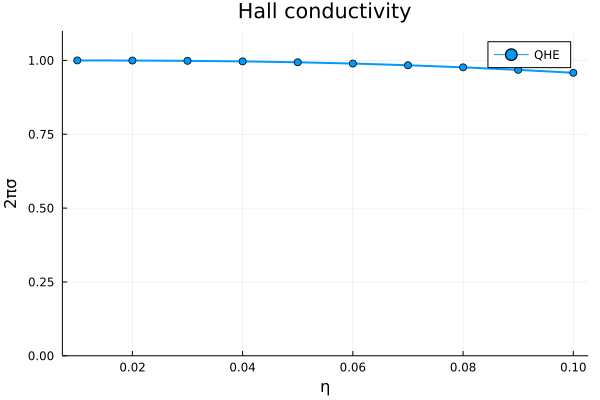

In [12]:
using Plots
plot(eta0, 2pi*QH_eta, label="QHE",xlabel="η",ylabel="2πσ",ylims=(0.0,1.1),title="Hall conductivity", width=2.0, marker=:circle)

## 3.6 光学伝導度の計算
使う人がいるかも知れないので、一応光学伝導度のコードも載せておく。

Inputの周波数を$\Omega$とすると、「Reduced density matrix + Length gauge + Relaxation time approximation」の結果は、
$$
\sigma^{\alpha\beta}(\Omega;\Omega) = \sum_n \Bigl\{\frac{ij^{\alpha}_nj^{\beta}_n}{\Omega+i\eta}f'(\epsilon_n) + \sum_{m\neq n}\bigl(\frac{ij^{\alpha}_{nm}j^{\beta}_{mn}}{(\Omega-(\epsilon_m-\epsilon_n)+i\eta)(\epsilon_n-\epsilon_m)}f(\epsilon_n)\bigr)-\bigl(n\leftrightarrow m\bigr)\Bigr\} 
$$

Green関数法による結果は、
$$
\sigma^{\alpha\beta}(\Omega;\Omega) = \frac{1}{\Omega}\int\frac{d\omega}{2\pi}Tr\Bigl[j^{\alpha}G^R(\omega+\Omega)j^{\beta}(G^R(\omega)-G^A(\omega)) + j^{\alpha}(G^R(\omega)-G^A(\omega))j^{\beta}G^A(\omega-\Omega)\Bigr]f(\omega)
$$

である。詳しくは拙著[PRB:103.195133(2021)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.103.195133)を参考にどうぞ。

In [13]:
@everywhere function Gk_opt(w::Float64, W1::Float64, p::Parm, Ham::Hamiltonian)
    #Green関数のinverse
    GR0::Array{ComplexF64,2} = -Ham.Hk + Matrix{Complex{Float64}}(w*I,2,2) + p.eta*Matrix{Complex{Float64}}(1.0im*I,2,2)

    GR::Array{ComplexF64,2} = inv(GR0)
    GA::Array{ComplexF64,2} = GR'
    dGR::Array{ComplexF64,2} = - GR * GR
    dGA::Array{ComplexF64,2} = - GA * GA
    GRmA::Array{ComplexF64,2} = GR - GA

    GRp0::Array{ComplexF64,2} = -Ham.Hk + Matrix{Complex{Float64}}((w+W1)*I,2,2) + p.eta*Matrix{Complex{Float64}}(1.0im*I,2,2)
    GRp::Array{ComplexF64,2} = inv(GRp0)

    GAm0::Array{ComplexF64,2} = -Ham.Hk + Matrix{Complex{Float64}}((w-W1)*I,2,2) - p.eta*Matrix{Complex{Float64}}(1.0im*I,2,2)
    GAm::Array{ComplexF64,2} = inv(GAm0)
    return GR, GA, dGR, dGA, GRmA, GRp, GAm
end

@everywhere function Green_OR(W1::Float64, p::Parm, H::Hamiltonian)
    XX::Float64 = 0.0
    YX::Float64 = 0.0

    for w = collect(Float64,-p.W_MAX:2*p.W_MAX/p.W_SIZE:p.W_MAX)
        G = Green(Gk_opt(w,W1,p,H)...)
        VXA::Array{ComplexF64,2} = H.Vx*G.GRmA
        XX += 2.0p.W_MAX*real(tr(H.Vxx*G.GRmA) + tr(H.Vx*G.GRp*VXA) + tr(VXA*H.Vx*G.GAm))*f(w,p.T)/p.W_SIZE/W1/(2.0pi)
        YX += 2.0p.W_MAX*real(tr(H.Vyx*G.GRmA) + tr(H.Vy*G.GRp*VXA) + tr(H.Vy*G.GRmA*H.Vx*G.GAm))*f(w,p.T)/p.W_SIZE/W1/(2.0pi)
    end
    return XX, YX
end

流石に20分くらいかかります

In [14]:
W1 = collect(0.1:0.1:2.0)
XX_W = zeros(Float64,length(W1))
YX_W = zeros(Float64,length(W1))
for j in 1:length(W1)
    p1 = Parm(0.4, 1.0, -1.0, 0, 0.01, 0.005, 2.2, 300, 2000)
    #そのままcollectすると要素が「(K_SIZE+1)*(K_SIZE+1)」になってしまうので(edgeでdouble countしている)、[1:end-1]とする事で、collectで集める部分を指定している。
    k = collect(Iterators.product((-pi:2*pi/p1.K_SIZE:pi)[1:end-1], (-pi:2*pi/p1.K_SIZE:pi)[1:end-1]))

    XX_W[j], YX_W[j] = @distributed (+) for i in 1:length(k)
        Hamk = Hamiltonian(HandV_topo(k[i],p1)...)
        XX, YX = Green_OR(W1[j],p1,Hamk)
        [XX/(p1.K_SIZE^2), YX/(p1.K_SIZE^2)]
    end
end

結果としてはこんな感じである。
DC limit($\Omega\rightarrow 0$)でちゃんと縦伝導が０、ホール伝導が1に近づいて行ってる。

次にtutorial3.ipynbで、非線形応答について計算していく。

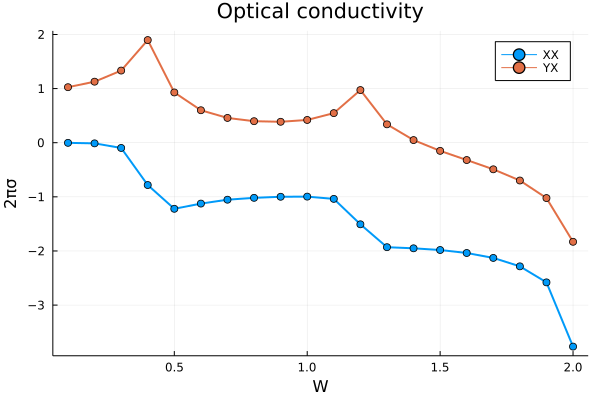

In [15]:
using Plots
plot(W1, 2pi*XX_W, label="XX",xlabel="W",ylabel="2πσ",title="Optical conductivity", width=2.0, marker=:circle)
plot!(W1, 2pi*YX_W, label="YX", width=2.0, marker=:circle)